<a href="https://colab.research.google.com/github/kn0wthing/Image-Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install cache

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
# import keras
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import cache

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

This was developed using Python 3.6 (Anaconda) and package versions:

In [6]:
tf.__version__

'2.6.0'

In [7]:
tf.keras.__version__

'2.6.0'

## Load Data

We will use the COCO data-set which contains many images with text-captions.

http://cocodataset.org

In [18]:
!pip install download

In [27]:
import json
import os
import sys
import os
import urllib.request
import tarfile
import zipfile

In [22]:
data_dir = "data/coco/"

train_dir = "data/coco/train2017"
val_dir = "data/coco/val2017"

data_url = "http://images.cocodataset.org/"


In [23]:
def set_data_dir(new_data_dir):
    global data_dir, train_dir, val_dir

    data_dir = new_data_dir
    train_dir = os.path.join(new_data_dir, "train2017")
    val_dir = os.path.join(new_data_dir, "val2017")


In [31]:
def download_and_extract(url, download_dir):
   
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  )

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

In [32]:
def dae():
    filenames = ["zips/train2017.zip", "zips/val2017.zip",
                 "annotations/annotations_trainval2017.zip"]

    for filename in filenames:
        url = data_url + filename

        print("Downloading " + url)

        download_and_extract(url=url, download_dir=data_dir)
        



In [34]:
def load_records(train=True):

    if train:
        filename = "captions_train2017.json"
    else:
        filename = "captions_val2017.json"

    path = os.path.join(data_dir, "annotations", filename)

    with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

    images = data_raw['images']
    annotations = data_raw['annotations']

    records = dict()

    for image in images:
        image_id = image['id']
        filename = image['file_name']

        record = dict()

        record['filename'] = filename

        record['captions'] = list()

        records[image_id] = record

    for ann in annotations:
        image_id = ann['image_id']
        caption = ann['caption']
        record = records[image_id]
        record['captions'].append(caption)

    records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]

    ids, filenames, captions = zip(*records_list)

    return ids, filenames, captions

In [25]:
set_data_dir("data/coco/")

In [ ]:
dae()

In [ ]:
_, filenames_train, captions_train = load_records(train=True)

In [ ]:
num_images_train = len(filenames_train)
num_images_train

118287

In [ ]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


In [ ]:
def load_image(path, size=None):
    img = Image.open(path)

    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    img = np.array(img)
    img = img / 255.0

    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

In [ ]:
def show_image(idx, train):

    if train:
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(dir, filename)

    for caption in captions:
        print(caption)
    
    img = load_image(path)
    plt.imshow(img)
    plt.show()

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


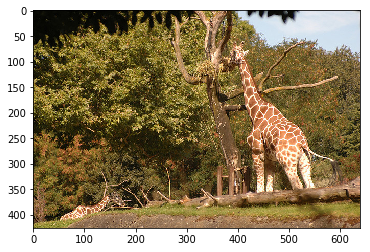

In [ ]:
show_image(idx=1, train=True)

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

In [ ]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
transfer_layer = image_model.get_layer('fc2')

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [ ]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [ ]:
def print_progress(count, max_count):
    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    num_images = len(filenames)

    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)

        end_index = start_index + batch_size

        if end_index > num_images:
            end_index = num_images

        current_batch_size = end_index - start_index

        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)
            image_batch[i] = img

        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        start_index = end_index

    print()

    return transfer_values

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Helper-function for processing all images in the validation-set.

In [ ]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [ ]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 116 ms, sys: 256 ms, total: 372 ms
Wall time: 365 ms


In [ ]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 16.7 ms


In [ ]:
mark_start = 'ssss '
mark_end = ' eeee'

In [ ]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [ ]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [ ]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [ ]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [ ]:
captions_train_flat = flatten(captions_train_marked)

In [ ]:
num_words = 10000

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 8.75 s, sys: 32 ms, total: 8.78 s
Wall time: 8.7 s


In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [ ]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 6.72 s, sys: 68 ms, total: 6.78 s
Wall time: 6.72 s


In [ ]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [ ]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [ ]:
def get_random_caption_tokens(idx):
    result = []

    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)

    return result

In [ ]:
def batch_generator(batch_size):
    while True:
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        transfer_values = transfer_values_train[idx]
        tokens = get_random_caption_tokens(idx)

        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [ ]:
batch_size = 1024

In [ ]:
generator = batch_generator(batch_size=batch_size)

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
batch_x['transfer_values_input'][0]

array([0.    , 0.    , 1.451 , ..., 0.    , 0.    , 0.6562], dtype=float16)

In [ ]:
batch_x['decoder_input'][0]

array([  2,   1, 126,  34,   5,   1,  29,  25,   1, 247, 116,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
batch_y['decoder_output'][0]

array([  1, 126,  34,   5,   1,  29,  25,   1, 247, 116,   3,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
num_captions_train = [len(captions) for captions in captions_train]

In [ ]:
total_num_captions_train = np.sum(num_captions_train)

In [ ]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

577

In [ ]:
state_size = 512

In [ ]:
embedding_size = 128

In [ ]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [ ]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [ ]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [ ]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [ ]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [ ]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [ ]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input
    
    net = decoder_embedding(net)
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [ ]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

In [ ]:
def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [ ]:
optimizer = RMSprop(lr=1e-3)

In [ ]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [ ]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    
    image_batch = np.expand_dims(image, axis=0)

    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start
    output_text = ''
    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int

        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)

        sampled_word = tokenizer.token_to_word(token_int)

        output_text += " " + sampled_word

        count_tokens += 1

    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    
    print("Predicted caption:")
    print(output_text)
    print()

In [1]:
generate_caption("images/parrot_cropped1.jpg")

NameError: ignored

In [ ]:
generate_caption("images/elon_musk.jpg")

In [ ]:
def generate_caption_coco(idx, train=False):
    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)

    generate_caption(image_path=path)

    print("True captions:")
    for caption in captions:
        print(caption)

In [ ]:
generate_caption_coco(idx=1, train=True)

In [ ]:
generate_caption_coco(idx=10, train=True)

In [ ]:
generate_caption_coco(idx=1, train=False)